## Download Chloris Open Data Biomass 2003-2017

In [15]:
import planetary_computer
import matplotlib.pyplot as plt
import rioxarray
import pystac_client
import geopandas as gpd
import mercantile
import stackstac
import pandas as pd
import xarray as xr 
from geogif import gif

https://planetarycomputer.microsoft.com/dataset/chloris-biomass#Example-Notebook 


In [4]:
co_boundary = gpd.read_file("/Users/marthamorrissey/Downloads/Colorado_State_Boundary.geojson")

<Axes: >

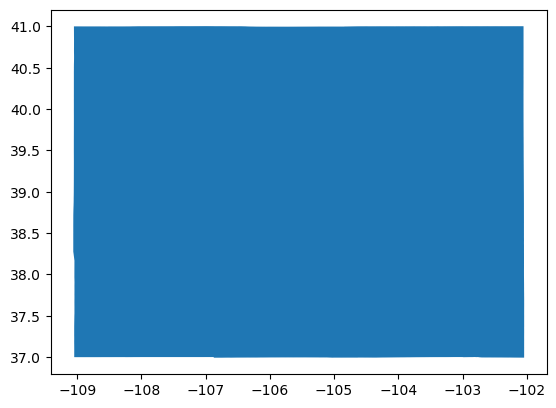

In [5]:
co_boundary.plot()

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
biomass = catalog.search(collections=["chloris-biomass"])

all_items = biomass.get_all_items()

/Users/marthamorrissey/mambaforge/envs/redwood-dev/lib/python3.10/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [9]:
all_items

In [7]:
biomass = catalog.search(collections=["chloris-biomass"], bbox=co_boundary.total_bounds)

In [8]:
# reproject to match 

co_boundary_reproject = co_boundary.to_crs("EPSG:3857")

In [9]:
dset_lst = []

for item in all_items:

    da = rioxarray.open_rasterio(item.assets["biomass_wm"].href, masked=True)

    # Transform our data array to a dataset by selecting the only data variable ('band')
    # renaming it to something useful ('biomass')
    ds = da.to_dataset(dim="band").rename({1: "biomass_wm"})
    ds = ds.rio.clip(co_boundary_reproject.geometry.values)

    dset_lst.append(ds)

In [11]:
dset_lst_wgs84 = [x.rio.reproject("EPSG:4326") for x in dset_lst]

In [12]:
dset_lst_wgs84

[<xarray.Dataset>
 Dimensions:      (x: 182, y: 104)
 Coordinates:
   * x            (x) float64 -109.1 -109.0 -109.0 ... -102.1 -102.1 -102.1
   * y            (y) float64 40.98 40.94 40.9 40.87 ... 37.12 37.08 37.04 37.0
     spatial_ref  int64 0
 Data variables:
     biomass_wm   (y, x) float64 nan 5.012e+04 7.052e+04 ... nan 74.0 62.0
 Attributes:
     AREA_OR_POINT:  Area
     scale_factor:   1.0
     add_offset:     0.0,
 <xarray.Dataset>
 Dimensions:      (x: 182, y: 104)
 Coordinates:
   * x            (x) float64 -109.1 -109.0 -109.0 ... -102.1 -102.1 -102.1
   * y            (y) float64 40.98 40.94 40.9 40.87 ... 37.12 37.08 37.04 37.0
     spatial_ref  int64 0
 Data variables:
     biomass_wm   (y, x) float64 nan 5.032e+04 7.046e+04 ... nan 74.0 62.0
 Attributes:
     AREA_OR_POINT:  Area
     scale_factor:   1.0
     add_offset:     0.0,
 <xarray.Dataset>
 Dimensions:      (x: 182, y: 104)
 Coordinates:
   * x            (x) float64 -109.1 -109.0 -109.0 ... -102.1 -102.1 -1

In [28]:
dset = xr.concat(dset_lst_wgs84, dim="time")

In [23]:
dset.time = pd.to_datetime(pd.Series(range(2003, 2021)), format='%Y')

In [29]:
dset

<xarray.Dataset>
Dimensions:      (x: 182, y: 104, time: 17)
Coordinates:
  * x            (x) float64 -109.1 -109.0 -109.0 ... -102.1 -102.1 -102.1
  * y            (y) float64 40.98 40.94 40.9 40.87 ... 37.12 37.08 37.04 37.0
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    biomass_wm   (time, y, x) float64 nan 5.012e+04 7.052e+04 ... 136.0 141.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [31]:
#g = gif(arr=dset["biomass_wm"], fps=1, cmap="viridis", robust=True)

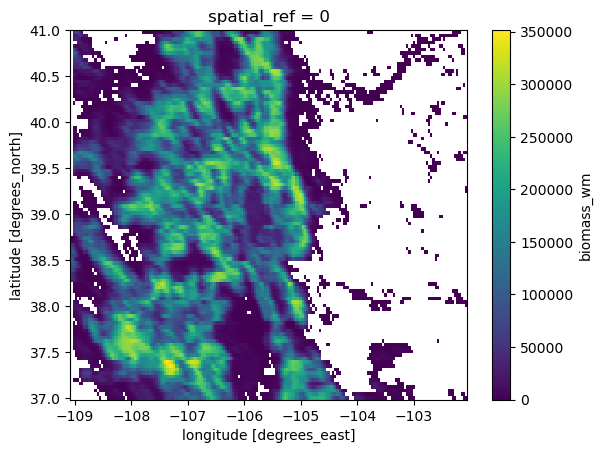

In [113]:
dset_lst_wgs84[0]['biomass_wm'].plot()

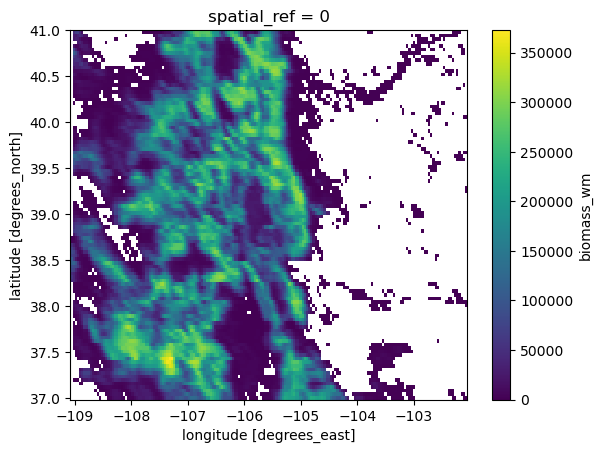

In [114]:
dset_lst_wgs84[-1]['biomass_wm'].plot()

In [102]:
clipped_2003 = dset_lst[0].rio.clip(co_boundary_reproject.geometry.values)